# Figure 9 - Denoising blood differentiation data (Paul et al.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import seaborn as sns
import scipy as sp
from dca.api import dca

import matplotlib
matplotlib.rc('pdf', fonttype=42)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

sc.settings.set_figure_params(dpi=200)
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (7,7)

Using TensorFlow backend.


## Load Paul15 dataset

In [2]:
adata = sc.datasets.paul15()

# replace Sfpi1 with Pu.1
genes = adata.var_names.to_native_types()
genes[genes == 'Sfpi1'] = 'Pu.1'
adata.var_names = pd.Index(genes)

adata.raw = adata.copy()

sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.dpt(adata, n_branchings=1)

adata

... storing 'paul15_clusters' as categorical


AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    uns: 'iroot', 'pca', 'neighbors', 'diffmap_evals', 'dpt_changepoints', 'dpt_grouptips'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'

## Calculate diffusion pseudotime and groups

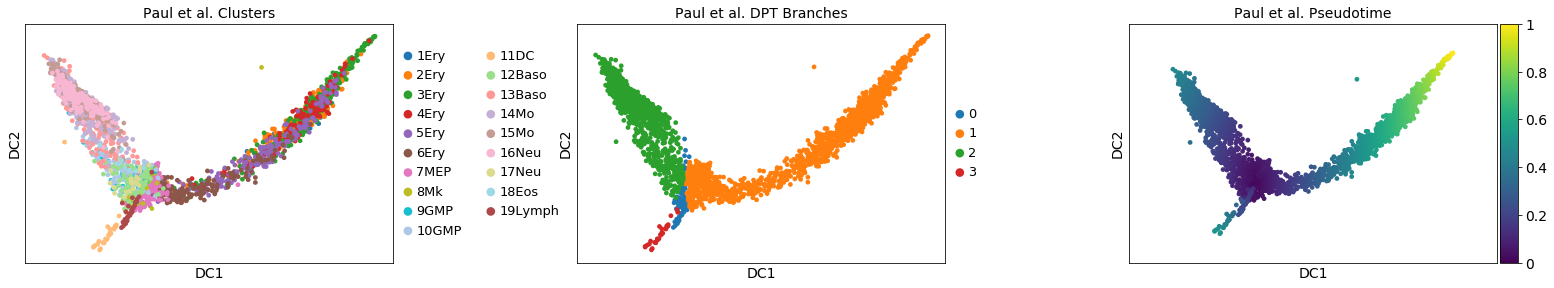

In [3]:
sc.pl.diffmap(adata, color=['paul15_clusters', 'dpt_groups', 'dpt_pseudotime'], size=90, title=['Paul et al. Clusters', 'Paul et al. DPT Branches', 'Paul et al. Pseudotime'])

## Visualize Pu.1 and Gata expression in MEP and GMP branches

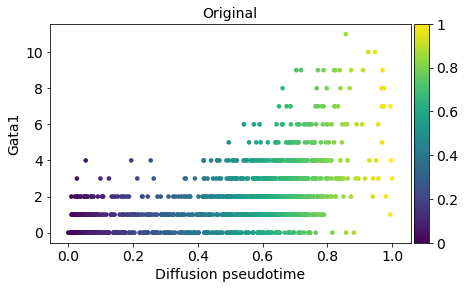

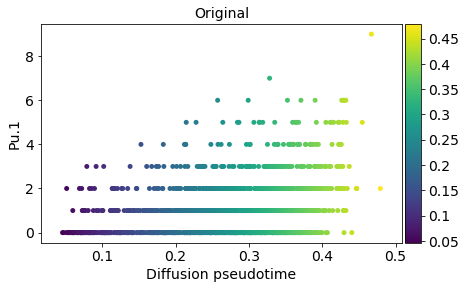

In [4]:
gene1 = 'Gata1'
gene2 = 'Pu.1'

ax = sc.pl.scatter(adata[adata.obs.dpt_groups == '1'], 'dpt_pseudotime', gene1, 
                   color='dpt_pseudotime', color_map='viridis', title='Original', show=False)
ax.set_xlabel('Diffusion pseudotime')

ax = sc.pl.scatter(adata[adata.obs.dpt_groups == '2'], 'dpt_pseudotime', gene2, 
                   color='dpt_pseudotime', color_map='viridis', title='Original', show=False)
ax.set_xlabel('Diffusion pseudotime');

## Denoise data using DCA

In [5]:
%%time

adata_ae = sc.datasets.paul15()

# replace Sfpi1 with Pu.1
genes = adata_ae.var_names.to_native_types()
genes[genes == 'Sfpi1'] = 'Pu.1'
adata_ae.var_names = pd.Index(genes)

dca(adata_ae, ae_type='nb')

... storing 'paul15_clusters' as categorical
dca: Successfully preprocessed 3451 genes and 2730 cells.
dca: Calculating reconstructions...
CPU times: user 10min 42s, sys: 2min 15s, total: 12min 58s
Wall time: 1min 59s


In [6]:
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)
sc.pp.neighbors(adata_ae, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.dpt(adata_ae, n_branchings=1)

adata_ae

AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters', 'dca_split', 'n_counts', 'size_factors', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    uns: 'iroot', 'pca', 'neighbors', 'diffmap_evals', 'dpt_changepoints', 'dpt_grouptips'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'

## Visualize Pu.1-Gata1 anticorrelation on denoised dataset

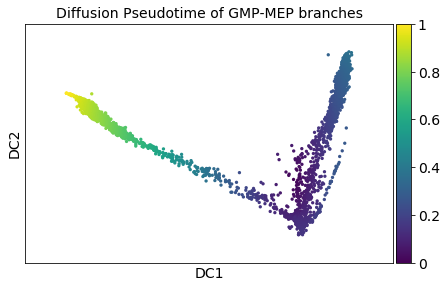

In [7]:
sc.pl.diffmap(adata_ae, color='dpt_pseudotime', title='Diffusion Pseudotime of GMP-MEP branches', color_map='viridis', use_raw=False)

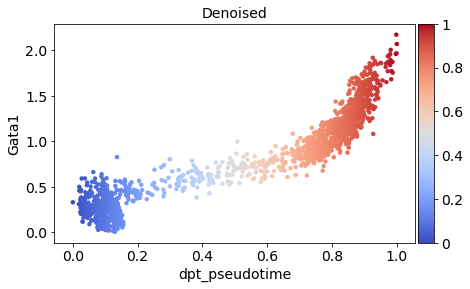

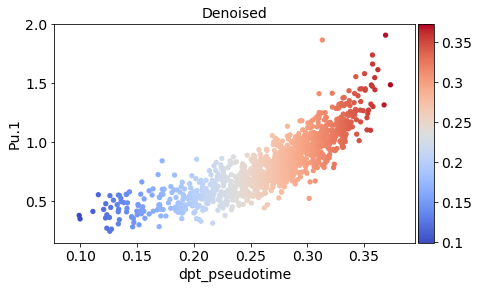

In [8]:
gene1 = 'Gata1'
gene2 = 'Pu.1'

sc.pl.scatter(adata_ae[adata_ae.obs.dpt_groups == '1'], 'dpt_pseudotime', gene1, 
              color='dpt_pseudotime', color_map='coolwarm', title='Denoised', use_raw=False)

sc.pl.scatter(adata_ae[adata_ae.obs.dpt_groups == '2'], 'dpt_pseudotime', gene2, 
              color='dpt_pseudotime', color_map='coolwarm', title='Denoised', use_raw=False)

## Visualize within and across marker group correlations

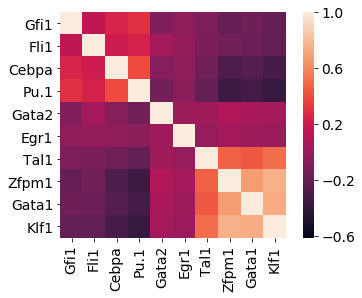

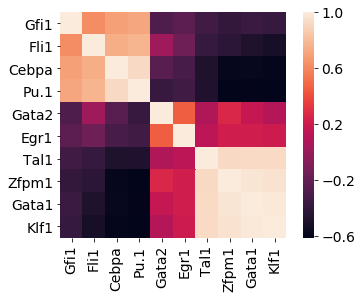

In [9]:
krumsiek_genes = 'Gfi1 Fli1 Cebpa Pu.1 Gata2 Egr1 Tal1 Zfpm1 Gata1 Klf1'.split()

kr_orig_cor_mat = np.corrcoef(adata[:, krumsiek_genes].X, rowvar=False)
kr_ae_cor_mat = np.corrcoef(adata_ae[:, krumsiek_genes].X, rowvar=False)

v1 = min(kr_orig_cor_mat.min(), kr_ae_cor_mat.min())
v2 = max(kr_orig_cor_mat.max(), kr_ae_cor_mat.max())

kr_orig_cor_mat = pd.DataFrame(kr_orig_cor_mat, index=krumsiek_genes, columns=krumsiek_genes)
kr_ae_cor_mat = pd.DataFrame(kr_ae_cor_mat, index=krumsiek_genes, columns=krumsiek_genes)


ax = sns.heatmap(kr_orig_cor_mat, vmin=v1, vmax=v2, square=True, cbar_kws={'ticks': np.linspace(-1, 1.0, 6)})

plt.figure()
sns.heatmap(kr_ae_cor_mat, vmin=v1, vmax=v2, square=True, cbar_kws={'ticks': np.linspace(-1, 1.0, 6)});

## Visualize differentiation using Pu.1 and Gata1

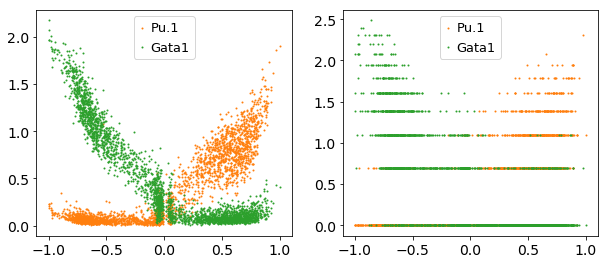

In [10]:
def sqz(x):
    x = x - x.min()
    return x / x.max()

adata_sorted = adata[adata.obs.dpt_order_indices].copy()
adata_sorted_ae = adata_ae[adata.obs.dpt_order_indices].copy()

obs = adata_sorted.obs.copy()
obs.loc[obs.dpt_groups.values == '1', 'dpt_pseudotime'] = -sqz(obs.loc[obs.dpt_groups.values == '1', 'dpt_pseudotime'])
obs.loc[obs.dpt_groups.values == '2', 'dpt_pseudotime'] = sqz(obs.loc[obs.dpt_groups.values == '2', 'dpt_pseudotime'])

adata_sorted.obs = obs
adata_sorted_ae.obs['dpt_pseudotime'] = adata_sorted.obs.dpt_pseudotime

f, axs = plt.subplots(1, 2, figsize=(10, 4))

X = adata_sorted_ae[np.isin(adata_sorted_ae.obs.dpt_groups.values, ('1', '2'))]
axs[0].scatter(X.obs.dpt_pseudotime.values, X[:, 'Pu.1'].X, s=1, c='C1', label='Pu.1')
axs[0].scatter(X.obs.dpt_pseudotime.values, X[:, 'Gata1'].X, s=1, c='C2', label='Gata1')
axs[0].legend();

X = adata_sorted[np.isin(adata_sorted.obs.dpt_groups.values, ('1', '2'))]
axs[1].scatter(X.obs.dpt_pseudotime.values, X[:, 'Pu.1'].X, s=1, c='C1', label='Pu.1')
axs[1].scatter(X.obs.dpt_pseudotime.values, X[:, 'Gata1'].X, s=1, c='C2', label='Gata1')
axs[1].legend();

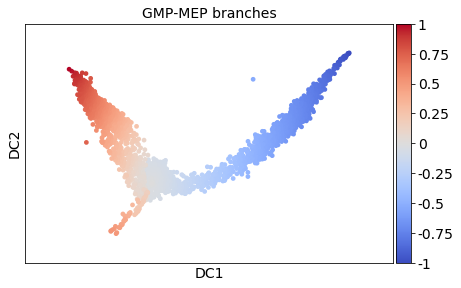

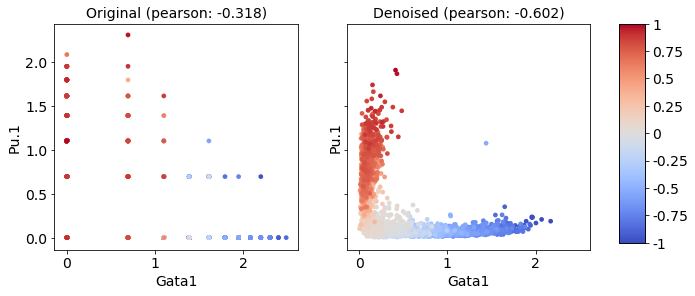

In [11]:
sc.pl.diffmap(adata_sorted, color='dpt_pseudotime', 
              title='GMP-MEP branches',
              color_map='coolwarm', size=90)

gene1 = 'Gata1'
gene2 = 'Pu.1'

f, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

coef = np.corrcoef(adata_sorted.X[:, adata.var_names == gene1].reshape(-1), 
                   adata_sorted.X[:, adata.var_names == gene2].reshape(-1))[0, 1]

sc.pl.scatter(adata_sorted[np.isin(adata_sorted.obs.dpt_groups.values, ('1', '2'))], 
              gene1, gene2, color='dpt_pseudotime', size=90, use_raw=False, ax=ax[0],
              color_map='coolwarm', title='Original (pearson: %.3f)' % coef, show=False)

coef = np.corrcoef(adata_sorted_ae.X[:, adata.var_names == gene1].reshape(-1), 
                   adata_sorted_ae.X[:, adata.var_names == gene2].reshape(-1))[0, 1]

sc.pl.scatter(adata_sorted_ae[np.isin(adata_sorted_ae.obs.dpt_groups.values, ('1', '2'))], 
              gene1, gene2, color='dpt_pseudotime', size=90, use_raw=False, ax=ax[1],
              color_map='coolwarm', title='Denoised (pearson: %.3f)' % coef, show=False)

plt.subplots_adjust(right=0.8)

## Supplementary Figure X: Plotting cells with zero Pu1-Gata1 expression

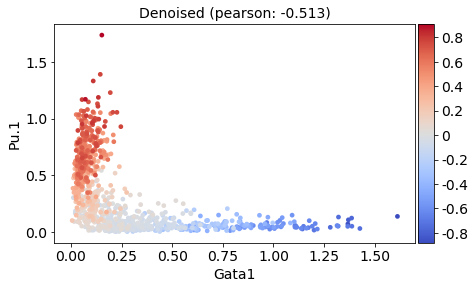

In [12]:
zero_idx = (adata_sorted.X[:, adata_ae.var_names.values == 'Pu.1'] == 0) & (adata_sorted.X[:, adata_ae.var_names.values == 'Gata1'] == 0)
zero_idx = zero_idx.ravel()

coef = np.corrcoef(adata_sorted_ae.X[zero_idx, adata_ae.var_names == gene1].reshape(-1), 
                   adata_sorted_ae.X[zero_idx, adata_ae.var_names == gene2].reshape(-1))[0, 1]

sc.pl.scatter(adata_sorted_ae[zero_idx, :],
              gene1, gene2, color='dpt_pseudotime',
              color_map='coolwarm', title='Denoised (pearson: %.3f)' % coef,
              show=True, size=90, use_raw=False)